# Comparative analysis description

# Input data description

# Setup

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("..")
import sys
import inspect
from IPython.display import clear_output
import relegy.embeddings as rle
import relegy.metrics as rlm
import relegy.graphs as rlr
from matplotlib.pylab import rcParams
import pandas as pd
os.chdir("Analysis")
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

In [10]:
def get_embedding_methods_iterable():
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

def plot_graph(graph):
    rcParams["figure.figsize"] = 5,5
    nx.draw(graph[0], node_color=graph[1])

def get_results_from_all_viable_methods(d, graphs, graph_names=None, labels=None):
    results = [None] * len(graphs)
    for i, G in tqdm(enumerate(graphs)):
        results_dictionary = {}
        for name, class_handle in get_embedding_methods_iterable():
            info = "Currently processing " + str(name) + ", d: " + str(d)
            if graph_names is not None:
                info += ", graph: " + graph_names[i]
            if not (name == "GCN"):
                if name in ["GraphWave", "HOPE", "LINE"]:
                    current_d = d // 2
                else:
                    current_d = d
                print(info)
                if name == "GNN":
                    labelsGNN = np.array([np.arange(len(labels[i])),labels[i]]).T
                    results_dictionary[name] = class_handle.fast_embed(G, embed_dim=current_d, idx_labels=labelsGNN)
                    clear_output()
                elif not (name == "HARP"):
                    results_dictionary[name] = class_handle.fast_embed(G, d=current_d)
                    clear_output()
                else:
                    temp_name = "HARP_Deepwalk"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d)
                    temp_name = "HARP_Node2Vec"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d, method = "Node2Vec")
                    clear_output()
        results[i] = results_dictionary
    return results

# Analysis

## Graphs

In [3]:
node_labels = np.genfromtxt(os.path.join("..","data","internet-industry-partnerships","internet-industry-partnerships.node_labels"))
edges = np.genfromtxt(os.path.join("..","data","internet-industry-partnerships","internet-industry-partnerships.edges"), delimiter=",").astype(int)
labels1 = node_labels.astype(int)
G1 = nx.Graph()
G1.add_edges_from(edges)
G1 = nx.convert_node_labels_to_integers(G1, first_label=0)

G2, labels2_ = rlr.get_karate_graph()
labels2_ = np.array(labels2_)[:, 1]
labels2 = (labels2_ == 'Mr. Hi').astype(int)

G3, labels3 = rlr.generate_clusters_graph(300, 3, 0.05, 0.5)

labels = [labels1, labels2, labels3]

### G1

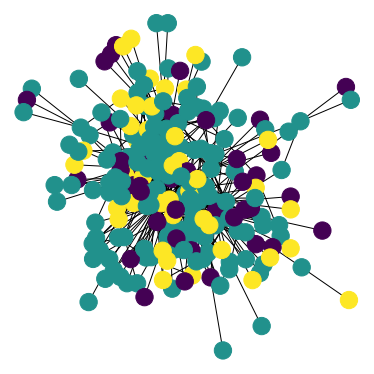

In [4]:
plot_graph((G1, labels1))
#plt.savefig("Classification/Classification-G1.png", transparent=True)

### G2

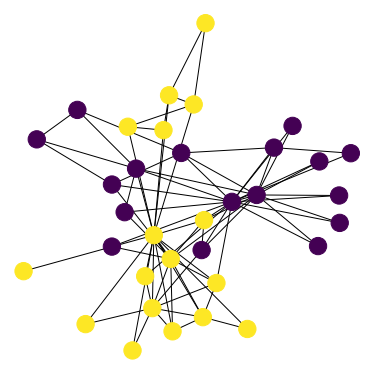

In [5]:
plot_graph((G2, labels2))
#plt.savefig("Classification/Classification-G2.png", transparent=True)

### G3

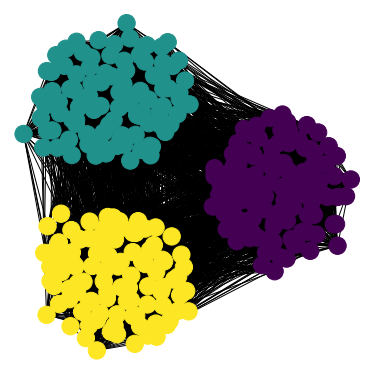

In [6]:
plot_graph((G3, labels3))
#plt.savefig("Classification/Classification-G3.png", transparent=True)

## Embeddings computation

In [11]:
results_d2 = get_results_from_all_viable_methods(d=2, graphs=[G1, G2, G3], graph_names=["G1", "G2", "G3"], labels=labels)
results_d6 = get_results_from_all_viable_methods(d=6, graphs=[G1, G2, G3], graph_names=["G1", "G2", "G3"], labels=labels)
results_d20 = get_results_from_all_viable_methods(d=20, graphs=[G1, G2, G3], graph_names=["G1", "G2", "G3"], labels=labels)
with open(f"Classification/G1_results_d2.p", "wb") as f:
    pickle.dump(results_d2[0], f)

with open(f"Classification/G1_results_d6.p", "wb") as f:
    pickle.dump(results_d6[0], f)

with open(f"Classification/G1_results_d20.p", "wb") as f:
    pickle.dump(results_d20[0], f)

with open(f"Classification/G2_results_d2.p", "wb") as f:
    pickle.dump(results_d2[1], f)

with open(f"Classification/G2_results_d6.p", "wb") as f:
    pickle.dump(results_d6[1], f)

with open(f"Classification/G2_results_d20.p", "wb") as f:
    pickle.dump(results_d20[1], f)

with open(f"Classification/G3_results_d2.p", "wb") as f:
    pickle.dump(results_d2[2], f)

with open(f"Classification/G3_results_d6.p", "wb") as f:
    pickle.dump(results_d6[2], f)

with open(f"Classification/G3_results_d20.p", "wb") as f:
    pickle.dump(results_d20[2], f)

In [12]:
embeddings_d2 = {}
for i in range(1, 4):
    with open(f"Classification/G{i}_results_d2.p", mode="rb") as f:
        embeddings_d2["G"+str(i)] = pickle.load(f)
embeddings_d6 = {}
for i in range(1, 4):
    with open(f"Classification/G{i}_results_d6.p", mode="rb") as f:
        embeddings_d6["G"+str(i)] = pickle.load(f)
embeddings_d20 = {}
for i in range(1, 4):
    with open(f"Classification/G{i}_results_d20.p", mode="rb") as f:
        embeddings_d20["G"+str(i)] = pickle.load(f)

## Classification task

In [13]:
reg_results_train_d2 = {"G1": {}, "G2":{}, "G3":{}}
reg_results_test_d2 = {"G1": {}, "G2":{}, "G3":{}}
for j in range(1, 4):
    names = embeddings_d2['G'+str(j)].keys()
    labels_cur = labels[j-1]
    reg_results = {}
    for i, name in enumerate(names):
        Z = embeddings_d2['G'+str(j)][name]
        X_train, X_test, y_train, y_test = train_test_split(Z, labels_cur, random_state=0)
        logreg = LogisticRegression(max_iter=400)
        logreg.fit(X_train, y_train)
        reg_results_train_d2["G"+str(j)][name] = logreg.score(X_train, y_train)
        reg_results_test_d2["G"+str(j)][name] = logreg.score(X_test, y_test)

In [15]:
reg_results_train_d6 = {"G1": {}, "G2":{}, "G3":{}}
reg_results_test_d6 = {"G1": {}, "G2":{}, "G3":{}}
for j in range(1, 4):
    names = embeddings_d6['G'+str(j)].keys()
    labels_cur = labels[j-1]
    reg_results = {}
    for i, name in enumerate(names):
        Z = embeddings_d6['G'+str(j)][name]
        X_train, X_test, y_train, y_test = train_test_split(Z, labels_cur, random_state=0)
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X_train, y_train)
        reg_results_train_d6["G"+str(j)][name] = logreg.score(X_train, y_train)
        reg_results_test_d6["G"+str(j)][name] = logreg.score(X_test, y_test)

In [16]:
reg_results_train_d20 = {"G1": {}, "G2":{}, "G3":{}}
reg_results_test_d20 = {"G1": {}, "G2":{}, "G3":{}}
for j in range(1, 4):
    names = embeddings_d20['G'+str(j)].keys()
    labels_cur = labels[j-1]
    reg_results = {}
    for i, name in enumerate(names):
        Z = embeddings_d20['G'+str(j)][name]
        X_train, X_test, y_train, y_test = train_test_split(Z, labels_cur, random_state=0)
        logreg = LogisticRegression(max_iter=800)
        logreg.fit(X_train, y_train)
        reg_results_train_d20["G"+str(j)][name] = logreg.score(X_train, y_train)
        reg_results_test_d20["G"+str(j)][name] = logreg.score(X_test, y_test)

In [17]:
G1_res_d2 = np.array(list(reg_results_test_d2["G1"].items()))
G2_res_d2 = np.array(list(reg_results_test_d2["G2"].items()))
G3_res_d2 = np.array(list(reg_results_test_d2["G3"].items()))

In [18]:
G1_res_d6 = np.array(list(reg_results_test_d6["G1"].items()))
G2_res_d6 = np.array(list(reg_results_test_d6["G2"].items()))
G3_res_d6 = np.array(list(reg_results_test_d6["G3"].items()))

In [19]:
G1_res_d20 = np.array(list(reg_results_test_d20["G1"].items()))
G2_res_d20 = np.array(list(reg_results_test_d20["G2"].items()))
G3_res_d20 = np.array(list(reg_results_test_d20["G3"].items()))

## Results

### All in one visualization

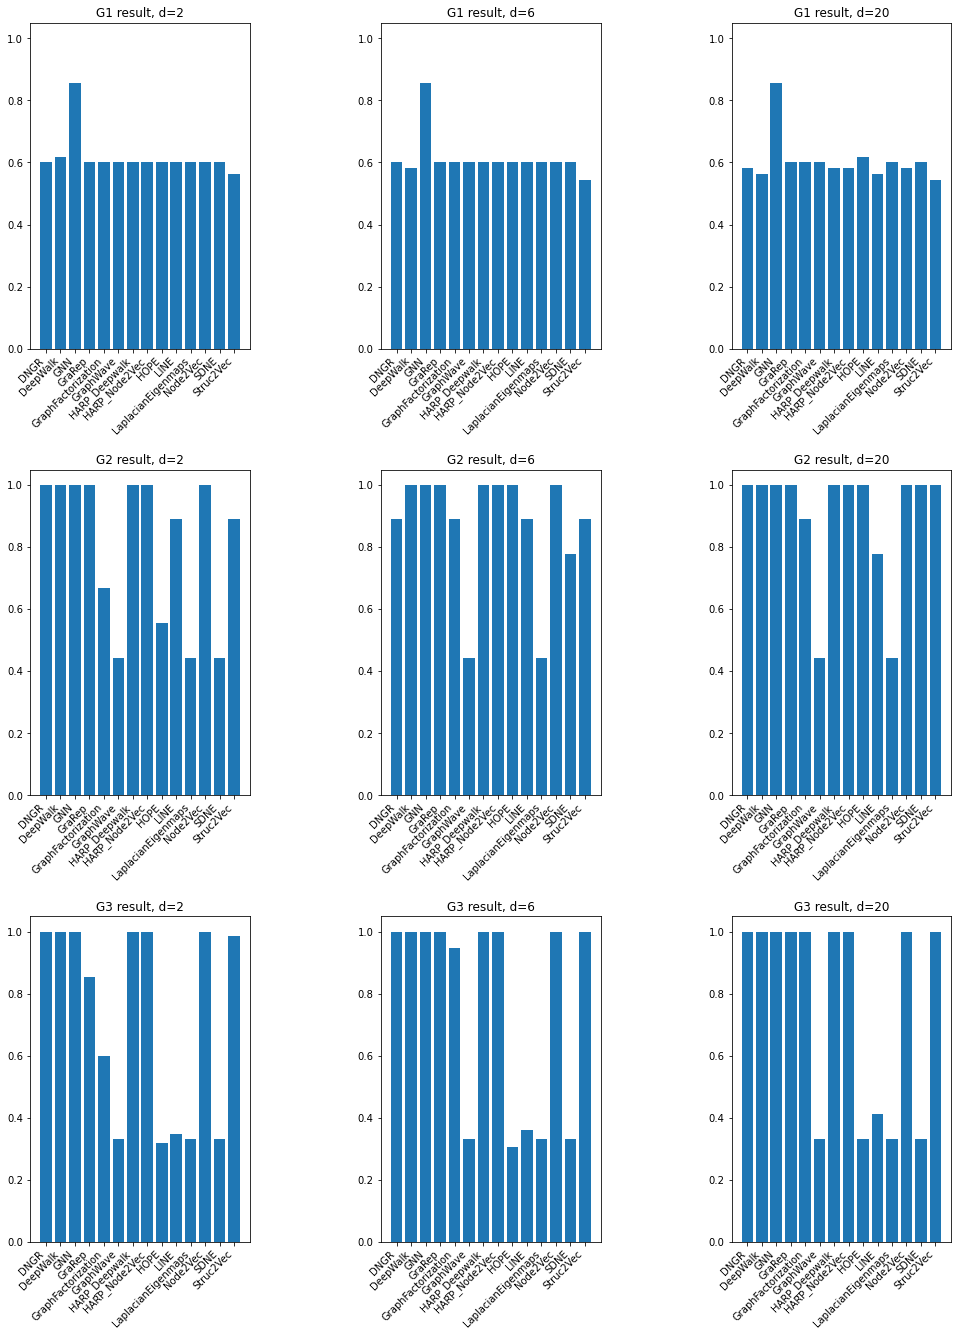

In [20]:
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 16, 20
fig, axs = plt.subplots(3, 3)
fig.tight_layout(pad=10.0)
plt.setp(axs[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[0, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[2, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[2, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(axs[2, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')
axs[0, 0].set_ylim(0,1.05)
axs[0, 1].set_ylim(0,1.05)
axs[0, 2].set_ylim(0,1.05)
axs[1, 0].set_ylim(0,1.05)
axs[1, 1].set_ylim(0,1.05)
axs[1, 2].set_ylim(0,1.05)
axs[2, 0].set_ylim(0,1.05)
axs[2, 1].set_ylim(0,1.05)
axs[2, 2].set_ylim(0,1.05)
axs[0, 0].set_title("G1 result, d=2")
axs[0, 0].bar(G1_res_d2[:, 0], np.round(G1_res_d2[:, 1].astype(np.float32), 3))
axs[1, 0].set_title("G2 result, d=2")
axs[1, 0].bar(G2_res_d2[:, 0], np.round(G2_res_d2[:, 1].astype(np.float32), 3))
axs[2, 0].set_title("G3 result, d=2")
axs[2, 0].bar(G3_res_d2[:, 0], np.round(G3_res_d2[:, 1].astype(np.float32), 3))
axs[0, 1].set_title("G1 result, d=6")
axs[0, 1].bar(G1_res_d6[:, 0], np.round(G1_res_d6[:, 1].astype(np.float32), 3))
axs[1, 1].set_title("G2 result, d=6")
axs[1, 1].bar(G2_res_d6[:, 0], np.round(G2_res_d6[:, 1].astype(np.float32), 3))
axs[2, 1].set_title("G3 result, d=6")
axs[2, 1].bar(G3_res_d6[:, 0], np.round(G3_res_d6[:, 1].astype(np.float32), 3))
axs[0, 2].set_title("G1 result, d=20")
axs[0, 2].bar(G1_res_d20[:, 0], np.round(G1_res_d20[:, 1].astype(np.float32), 3))
axs[1, 2].set_title("G2 result, d=20")
axs[1, 2].bar(G2_res_d20[:, 0], np.round(G2_res_d20[:, 1].astype(np.float32), 3))
axs[2, 2].set_title("G3 result, d=20")
axs[2, 2].bar(G3_res_d20[:, 0], np.round(G3_res_d20[:, 1].astype(np.float32), 3))
plt.show()

### Visualizations for separate files

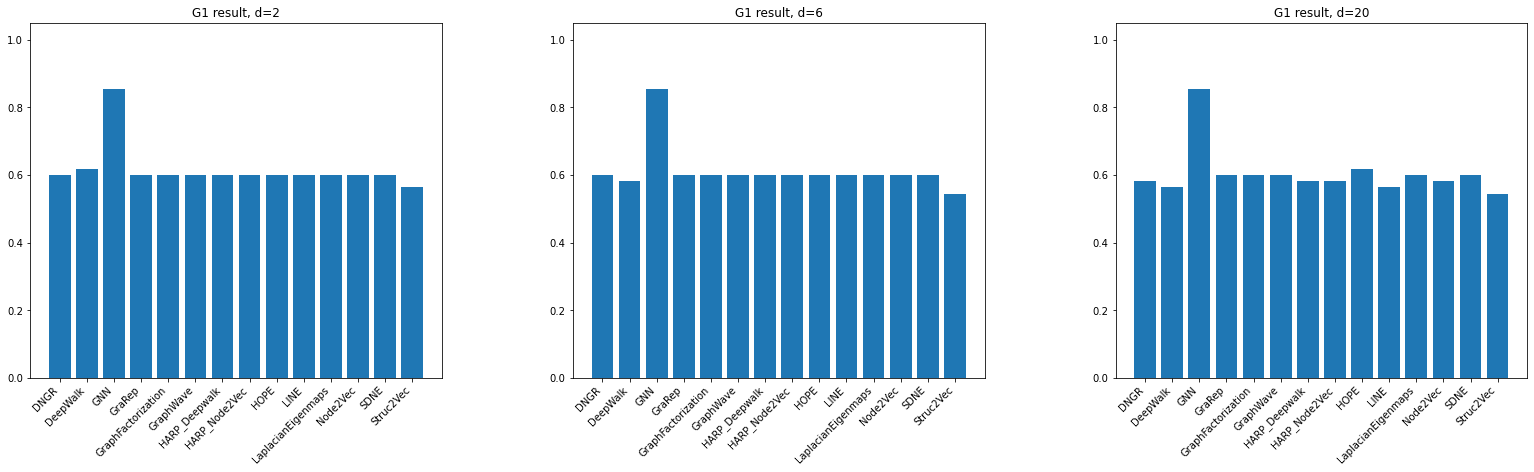

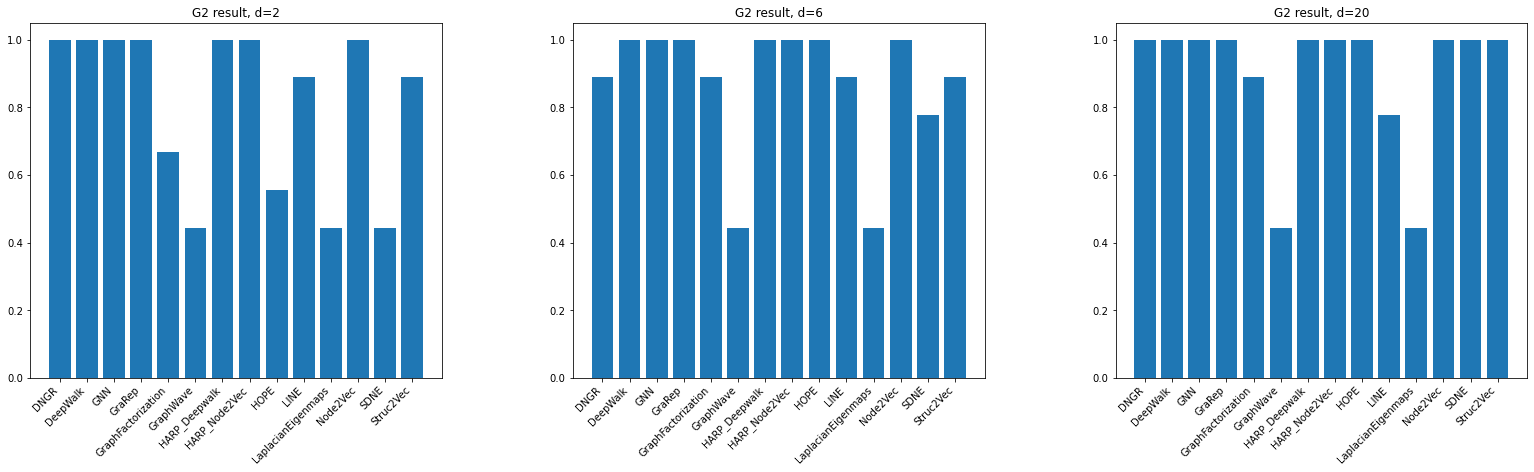

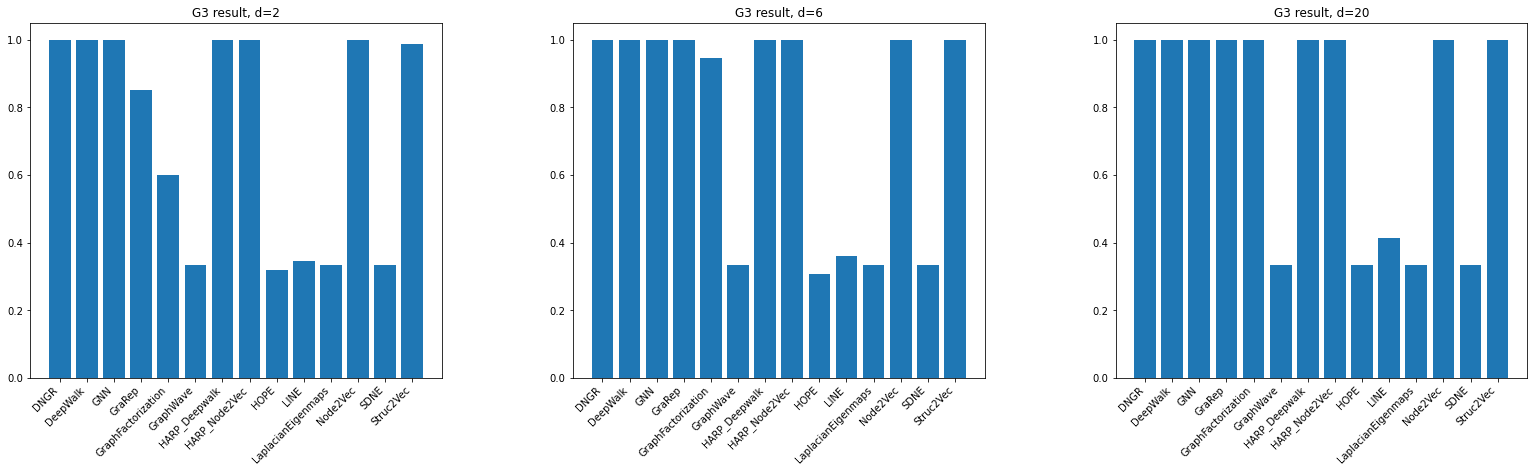

In [23]:
rcParams["figure.figsize"] = 24, 8
G_results = [[G1_res_d2,G1_res_d6,G1_res_d20],[G2_res_d2,G2_res_d6,G2_res_d20],[G3_res_d2,G3_res_d6,G3_res_d20]]
G_names = ["G1","G2","G3"]
d_vals = [2, 6, 20]

for name, d_results in zip(G_names, G_results):
    fig, axs = plt.subplots(1, 3)
    fig.tight_layout(pad=10.0)
    for i, (d, results) in enumerate(zip(d_vals,d_results)):
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axs[i].set_ylim(0,1.05)
        axs[i].set_title(f"{name} result, d={d_vals[i]}")
        axs[i].bar(results[:, 0], np.round(results[:, 1].astype(np.float32), 3))
    plt.savefig(f"Classification/Classification-{name}-results.png", transparent=True)
plt.show()

### Saving accuracies to csv

In [24]:
G_results = [[G1_res_d2,G1_res_d6,G1_res_d20],[G2_res_d2,G2_res_d6,G2_res_d20],[G3_res_d2,G3_res_d6,G3_res_d20]]
G_names = ["G1","G2","G3"]
d_vals = [2, 6, 20]

for name, d_results in zip(G_names, G_results):
    for d, results in zip(d_vals, d_results):
        df = pd.DataFrame(list(zip(results[:,0], np.round(results[:,1].astype(np.float32), 3))), columns=["Method","Accuracy"])
        df.to_csv(f"Classification/{name}-d{d}-accuracy.csv", index=False)